# 10 digit subspace classification 

### Group Formation and General Instructions
You may work individually, but we recommend that you work in pairs or groups of three. Find someone to work with and introduce yourself to them! One of you should copy the Google Document template and share the document with edit permissions with your group member(s): 
https://docs.google.com/document/d/1xRxhI8c0O3VI8XOwv0mM11j_up58sRicA5TfNa2COss/template/preview (you must use your umich email address to access this google document). 


The Google Document will include your answers to a couple of questions that will be asked. For each question, pick someone to type up your **group's** response. After completing the response, the group member should sign their name by typing it below the answer. For the next question, have a different group member respond and sign their name in the same way. Keep rotating until all the questions have been answered.

The goal of this group exercise is to formulate your response as a group to the problem. When finished, **one** student in the group must submit a PDF of the google document to gradescope, entering the uniquenames of **all** students in the group. One group submits exactly one PDF, but we expect the PDF from different groups to differ. The deadline for submitting to gradescope will be announced on Canvas. Only submit the filled-in google document; do not submit a download of this Jupyter notebook. 

### Overview

This goal of this task is to classify 10 handwritten digits using projection onto the nearest subspaces, where the subspaces for each digit is learned via the SVD (of the training data). 

This task generalizes task-2 to subspace classification for 10 digits. As part of the generalization, you must now think about storing variables for all 10 digits without creating separate train0, train1, train2, ... variables and similarly for other variables used throughout the code.

Suppose:
- ``test`` is an m x T matrix whose length-m columns contain T vectorized test images to be classified 
- ``train`` is an m x n x 10 matrix containing n vectorized training images for each digit 0-9 (in ascending order along the third dimension of ``train``). 
- k is an integer between 1 and min(m,n) and is the number of singular vectors to use during classification

In this task, you will write a function called ``classify_image`` that does the following, in order: 
- Compute the ten matrices (with orthonormal columns) with ranges that span the first k left singular vectors associated with the training images of each digit, respectively. For digit d = 0, . . . , 9 these are the k left singular vectors associated with the k largest singular values of the dth “slice” of train.
- Store each of the matrices 
- Use these matrices to compute the squared-norm of the error vector between each test image and the projection of each test image onto the k-dimensional subspaces spanned by each digit. Store the squared error in a 10 × T matrix — call it err.


In [1]:
import Pkg; Pkg.add("BenchmarkTools")
using Plots, LinearAlgebra
using BenchmarkTools

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed BenchmarkTools ─ v1.2.0
    Updating `~/.julia/environments/v1.6/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.2.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.2.0
  [9abbd945] + Profile
Precompiling project...
  ✓ BenchmarkTools
  1 dependency successfully precompiled in 12 seconds (244 already precompiled)


## Part 0: Download and prep the data
We now have to download data for all 10 digits. Here, we do that and store the result into the variable ``data``. Note the dimensions of ``data`` are (nx*ny) x (number of samples) x (number of digits). This means that every "column" (first dimension) of data is a single (vectorized) image! 

We then split the data up into training and testing samples. 

In [2]:
# read the MNIST data file for all digits
# download from web if needed
files = ["data$i" for i = 0:9]
for i = 1:length(files)
    if !isfile(files[i])
        download("http://cis.jhu.edu/~sachin/digit/" * files[i], files[i])
    end
end
D = length(files) # number of digits
nx = 28 # original image size
ny = 28
nrep = 1000

data = zeros(Float32, nx*ny, nrep, D)
for i = 1:D
    d = Array{UInt8}(undef, (nx*ny,nrep))
    read!(files[i], d)
    data[:,:,i] = d
end

@show(size(data)); # each column of the data matrix is one image! 

size(data) = (784, 1000, 10)


Based on this size of data, we have: 
- 784 pixels in each image
- 1000 images of each digit (1000 zeros, 1000 ones, ... 1000 nines)
- 10 digits (0 through 9)

## Part 1: Compute basis for a small subset of digits

Our final classify_image function will take a while to run on the full dataset. To help with debugging the function quickly while building it, here we only use a few digits and a few training and testing images. You should write the code so that it generalizes though! 

There is nothing you need to turn in for this part. 

In [175]:
# make a new, smaller dataset for us to use while debugging 
K = 5 # number of singular vectors to use for the basis 
# later, this will be an input to our function - pick a value just for testing 
ndigits = 3  # number of digits 
ntrain = 50  # number of training images per digit
ntest = 60   # number of testing images per digit
train = data[:,1:ntrain, 1:ndigits]
# testl where "l" is for "labelled" since it's still organized by true digit
testl = data[:,(ntrain+1):(ntest+ntrain), 1:ndigits] 
@show(size(train), size(testl));


size(train) = (784, 50, 3)
size(testl) = (784, 60, 3)


In [208]:
testl

784×744×10 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0

In [176]:
# TODO  

# form the test variable as a reshaped version of testl 
# test should be n x p (as described in the classify_image preamble)
# n is the dimension of our vector (the number of pixels in each image)
# p is the number of test vectors  

# test = ? 

test = reshape(testl, nx*ny,ntest*ndigits )
@show(size(test));

size(test) = (784, 180)


In [177]:
size(train)

(784, 50, 3)

In [178]:
# TODO  

# define the variables n, p, m, and d using only the test and train variables 
# n is the dimension of our vector (the number of pixels in each image)
# p is the number of test vectors  
# m is the number of training samples we have per digits 
# d is the number of digits 
n = size(test)[1]
p = size(test)[2]
m = size(train)[2]
d = size(train)[3]
println(n)
println(p)

784
180


In [179]:
# TODO  

# Construct the 10 basis for each digit and store them in a n x K x d array called Q 
# For digit d= 0,...,9, the basis are the K left singular vectors associated with the K 
#    largest singular values of the dth “slice” of train
Q = zeros(n, K, d)
for i in 1:d
    U,s,v = svd(train[:,:,i])
    Uk = U[:,1:K]
    Q[:,:,i] = Uk 
end


@show size(Q)

size(Q) = (784, 5, 3)


(784, 5, 3)

In [180]:
# TODO 

# Using only Q, compute the squared-norm of the 
# error vector between each test image and the projection of each test image onto 
# the K-dimensional subspaces spanned by each digit. Store the squared error in a 
# 3 × p matrix called err.

# Hint: You can express this computation succinctly for digit i=0,...,9 via the command
# err[i,:] = sum((test−Q[:,:,i]*(Q[:,:,i]'*test)).^2, dims=1)
err = zeros(d, p)
for i in 1:d
    err[i,:] = sum((test - Q[:,:,i]*(Q[:,:,i]'*test)).^2, dims=1)
end

display(err) 

3×180 Matrix{Float64}:
 1.48901e6  1.92467e6  1.00869e6  …  2.90464e6  5.37917e6  2.48572e6
 6.69623e6  5.7286e6   7.9245e6      2.6974e6   4.85853e6  3.05955e6
 4.96908e6  4.58908e6  5.3975e6      2.09032e6  2.07445e6  1.76328e6

In [181]:
# TODO 

# generate a vector — call it labels — containing the digit 
# (for each test image) with the smallest squared error.

labels = argmin(err, dims=1) 
labels = map(ii -> ii[1]-1, argmin(err, dims = 1));
# Hint: You can compute this for all digits at once using `argmin` and list comprehension 
# Hint: make sure your labels make sense before moving on. You know the class of these images
# and this classifier should have reasonably high accuracy! 
@show(size(labels));

size(labels) = (1, 180)


In [182]:
labels

1×180 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  2  2  2  2  2  2  2  2  2  2  2  2

In [183]:
# test out how we did on the small dataset (we will compare to this answer later when 
# testing the classify_image function)
labels_svd = reshape(labels, 1, ntest, d) # the 1 is because we only tested a single K value so far 
correct_svd = cat([labels_svd[:,:,i] .== i-1 for i = 1:d]..., dims = 3)
percent_correct_svd = dropdims(sum(correct_svd, dims = 2), dims = 2) .* (100 / ntest)

# Check your solution before continuing: [96.7 98.3 90.0]

1×3 Matrix{Float64}:
 96.6667  98.3333  90.0

## Part 2: Put everything together into the classify_image function
Now we will form the classify_image function. This should involve taking pieces of code from above. When you are done writing this function, test your work on a small subset of the images then submit to autograder. 

There is no separate submission for this part. You only need to submit your code to the autograder. 
**Even if you are working in a group, every group member should submit the code to the autograder to receive credit.** 

Hint: When sumbitting to autograder, make sure to include any packages you need with "using" statements! 

In [184]:

size(train)

(784, 50, 3)

In [187]:
# TODO 

"""
    labels = classify_image(test, train, K::Int)

Classify `test` signals using `K`-dimensional subspaces
found from `train`ing data via SVD

In:
* `test` `n x p` matrix whose columns are vectorized test images to be classified
* `train` `n x m x 10` array containing `m` training images for each digit 0-9 (in ascending order)
* `K` in `[1, min(n, m)]` is the number of singular vectors to use during classification

Out:
`labels` vector of length `p` containing the classified digits (0-9) for each test image
"""
function classify_image(test, train, K::Int)
    n = size(test)[1]
    p = size(test)[2]
    m = size(train)[2]
    d = size(train)[3]
    
    Q = zeros(n, K, d)
    for i in 1:d
        U, _, _= svd(train[:,:,i])
        Uk = U[:,1:K]
        Q[:,:,i] = Uk 
    end
    
    err = zeros(d, p)
    for i in 1:d
        err[i,:] = sum((test - Q[:,:,i]*(Q[:,:,i]'*test)).^2, dims=1)
    end
 
    labels = map(ii -> ii[1]-1, argmin(err, dims = 1));
    return labels
    
end


classify_image

## Test your classify_image function before submitting to autograder 
Before submitting your classify_image function to the autograder, check that you can run it and that you get the same result for the small test and train sets that we worked with in part 1. 

Once you have this working, submit the classify_image function to the autograder. 

In [188]:
labels = classify_image(test, train, K)

# test out how we did on the small samples (we will compare to this answer later when 
# testing the classify_image function)
labels_svd = reshape(labels, 1, ntest, d) # the 1 is because we only tested 1 K value so far 
correct_svd = cat([labels_svd[:,:,i] .== i-1 for i = 1:d]..., dims = 3)
percent_correct_svd = dropdims(sum(correct_svd, dims = 2), dims = 2) .* (100 / ntest)

# Check your answer before continuing: make sure you get the same values as your result from part 1! 

1×3 Matrix{Float64}:
 96.6667  98.3333  90.0

## Part 3: Class classify_image results on MNIST dataset 
We now move on to calling the classify_image function on the full dataset. Because this is a somewhat large dataset, some of these commands will take a while to run, so make sure you have a working classify_image function before moving on!

First, use your classify_image function to classify the MNIST test data. Because we are
now classifying all 10 digits, more training data may be helpful, so here use 256 images for training and the
remaining 744 for testing, for each digit.
For efficiency, you should call your classify_image function only once per k, not 100’s of times! Otherwise
you will be waiting a long time.

Turn in a single plot with 10 (labeled!) curves on it showing the percent of the test digits correctly classified
versus k for each of the ten digits. Examine k from 1 to at least 50.

In [198]:
# set up the data variables to now use the full dataset
d = D # use all the digits 
ntrain = 256 # more than previously used because we are classifying all 10 digits 
ntest = nrep - ntrain
@show(ntest)
train = data[:,1:ntrain,:] # train here is 784 x 256 x 10 = (nx x ny) x ntrain x ndigits 
testl = data[:,ntrain+1:end,:] # testl ("labelled") here is 784 x 744 x 10 = (nx x ny) x ntest x ndigits 
# you will need to reshape testl before calling classify_image! 

test = reshape(testl, nx*ny,ntest*d )
@show(size(train), size(testl));

ntest = 744
size(train) = (784, 256, 10)
size(testl) = (784, 744, 10)


In [199]:
# TODO 

# call the classify_image function. 

# This block takes ~1.5 minutes to run on my laptop
# Using projection matrices, it takes about 40 minutes! 

# TODO: define testr so that it is a n x p matrix we can use for input to class_image 

# set kmax to be at least 50 
kmax = 50
labels_svd = -ones(kmax, ntest*D) # why are we using -ones() instead of zeros() for initialization? 

@time( # this could take a minute or so   
for k = 1:kmax
    if mod(k,10)==0; @show(k); end # so you know your code is running 
    # TODO: call your classify_image function here to fill in the kth row of labels_svd
    labels_svd[k,:] = classify_image(test, train, k)

end
)

k = 10
k = 20
k = 30
k = 40
k = 50
173.700971 seconds (15.22 k allocations: 67.966 GiB, 5.50% gc time)


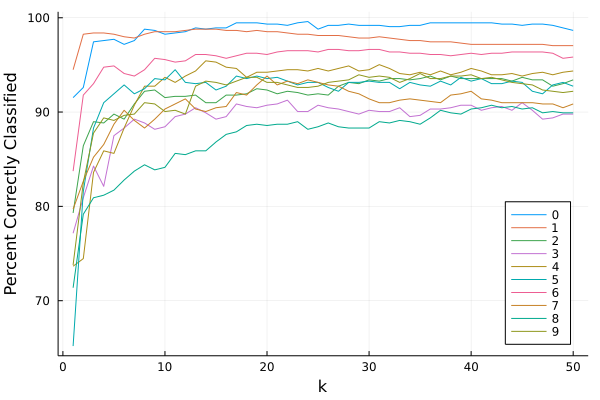

In [200]:
# plot the percentage correct vs k for each of the digits 
labels_svd = reshape(labels_svd, kmax, ntest, D)
correct_svd = cat([labels_svd[:,:,i] .== i-1 for i = 1:D]..., dims = 3)
percent_correct_svd = dropdims(sum(correct_svd, dims = 2), dims = 2) .* (100 / ntest)
plot(percent_correct_svd, label = hcat(["$i" for i = 0:9]...), ylabel = "Percent Correctly Classified", 
    xlabel = "k", legend = :bottomright)

## Part 4: Scree plot and selecting k
Plot the singular values associated with the training images for each digit. (Submit 1 or 2 of these plots, not all
10, or put several on one plot if it is still interpretable.) Discuss how close to the optimal performance you
get when you select the value of k associated with the “gap” in the singular value spectrum.

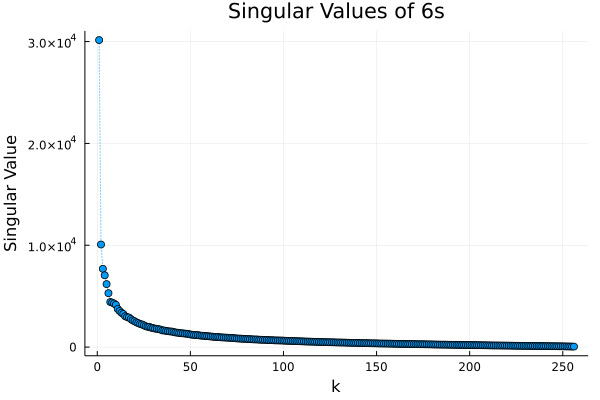

In [201]:
# Here is an example of a plot of the singular values
# TODO: You should plot at least one other! This could be in a separate plot or in the same plot. 
train6 = train[:,:,7]
_,s,_ = svd(train6)
plot(s, marker = :circle, line = :dot, label = "", title = "Singular Values of 6s", ylabel = "Singular Value", xlabel = "k")

In [202]:
# TODO 
# Visually determine the value of k associated with the "gap" in the singular value spectrum 
# and discuss how the performance of the classifier at that value of k compares to the optimal 
# performance 
total_correct_svd = [tr([sum(labels_svd[k,:,j] .== i-1) for i = 1:D, j = 1:D]) for k = 1:kmax]
optk = argmax(total_correct_svd)


# Hint: here is some code for finding the k associated with the optimal performance 
# total_correct_svd = [tr([sum(labels_svd[k,:,j] .== i-1) for i = 1:D, j = 1:D]) for k = 1:kmax]
# optk = argmax(total_correct_svd)


40

In [203]:
#Alternate math for finding k associated with optimal performance
total_correct_svd = [sum([sum(labels_svd[k,i,:] .== 0:9) for i=1:ntest]) for k=1:kmax]
optk = argmax(total_correct_svd)
# how well the classification compares will depend on your choice for K

40

In [205]:
percent_correct_svd[1,:]

10-element Vector{Float64}:
 91.53225806451613
 94.48924731182795
 79.3010752688172
 77.1505376344086
 73.65591397849462
 65.18817204301075
 83.73655913978494
 79.70430107526882
 71.37096774193547
 73.79032258064515

In [204]:
percent_correct_svd[40,:]

10-element Vector{Float64}:
 99.46236559139784
 97.1774193548387
 93.54838709677419
 90.7258064516129
 94.6236559139785
 93.2795698924731
 96.23655913978494
 92.20430107526882
 90.32258064516128
 93.9516129032258

In [206]:
percent_correct_svd[50,:]

10-element Vector{Float64}:
 98.65591397849462
 97.04301075268816
 93.41397849462365
 89.78494623655914
 94.35483870967741
 92.74193548387096
 95.83333333333333
 90.86021505376344
 89.91935483870967
 92.20430107526882

## Optional: Extra visualizations
Here, we've provided some code that looks at how well the classify_image function performs for different values of K. There is no code you have to fill in and you do not have to turn in these plots, but your optional task is to figure out what the code is doing and why it might be helpful! In other words, this is asking you to reverse-engineer our solution code. 

This sections is responding to the following prompt: 

Try nearest-mean-training-digit-based classification instead. Or, because it is simpler, you may re-use your same
routine and simply project onto the one-dimensional subspace spanned by the mean of each set of training images.
Show graphically the classification accuracy How much better is SVD-based classification?

In [18]:
confmat_svd_r1 = [sum(labels_svd[1,:,j] .== i-1) for i = 1:D, j = 1:D] 
confmat_svd_opt = [sum(labels_svd[optk,:,j] .== i-1) for i = 1:D, j = 1:D]
@show(tr(confmat_svd_r1), tr(confmat_svd_opt));
plot(heatmap(0:9, 0:9, confmat_svd_r1, title = "Rank 1"),
    heatmap(0:9, 0:9, confmat_svd_opt, title = "Optimal k"),
    yflip = true, aspect_ratio = :equal, xticks = 0:9, yticks = 0:9,
    xlabel = "True Digit", ylabel = "Predicted Digit")


LoadError: UndefVarError: labels_svd not defined

In [19]:
display("confmat_svd_r1"); display(confmat_svd_r1)
display("confmat_svd_opt"); display(confmat_svd_opt)

"confmat_svd_r1"

LoadError: UndefVarError: confmat_svd_r1 not defined